In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re, string, unicodedata
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
import re
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt

In [2]:
%%time
df = pd.read_csv(r"..\data\IMDB-Dataset.csv", encoding='latin-1')

CPU times: total: 1.17 s
Wall time: 3.51 s


In [3]:
df.drop(['Movies', 'Resenhas'], axis=1, inplace=True)

# Data Cleaning and Preprocessing

In [4]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
new_stopwords = ['movie', 'one', 'film', 'would', 'shall', 'could', 'might']
stop_words.extend(new_stopwords)
stop_words.remove('not')
stop_words = set(stop_words)


In [5]:
'''-----Data Cleaning and Prepocessing Pipeline'''

# Removing special character
def remove_special_char(content):
    return re.sub('\[[^&@#!]]', '', content)

# Removing url
def remove_url(content):
    return re.sub(r'http\S+', '', content)

# Removing stop_words from text
def remove_stopwords(text):
    clean_data = []
    for word in text.split():
        if word.strip().lower() not in stop_words and word.strip().lower().isalpha():
            clean_data.append(word.strip().lower())
    return " ".join(clean_data)

# Expansion of english contractions
import contractions
def contraction_expansion(content):
    return contractions.fix(content)

def data_cleaning(content):
    content = remove_special_char(content)
    content = remove_url(content)
    # We need to take care that we must expand the contraction before removing the stop words
    content = contraction_expansion(content)
    content = remove_stopwords(content)
    return content

In [6]:
%%time
# Data cleaning
df['Clean_Reviews'] = df['Reviews'].apply(data_cleaning)
df['Clean_Reviews'].head(5)

CPU times: total: 36.5 s
Wall time: 1min 4s


0    watched conditional see films not caught dead ...
1    writing hopes gets put previous review anyone ...
2    write scathing review turd going making observ...
3    saw previous spoof movies two horrible know al...
4    saw day early free still feel like got ripped ...
Name: Clean_Reviews, dtype: object

## Data Overview

In [7]:
df.isna().sum()

Ratings    0
Reviews    0
dtype: int64

In [8]:
df['Ratings'].describe()

count    150000.000000
mean          5.500000
std           2.872291
min           1.000000
25%           3.000000
50%           5.500000
75%           8.000000
max          10.000000
Name: Ratings, dtype: float64

In [14]:
df['Reviews'].describe()

count     150000
unique    149744
top             
freq          10
Name: Reviews, dtype: object

In [15]:
print("Number of unique reviews is: %s" % df.Reviews.nunique())
print("Number of ratings: %s" % df.Ratings.count())

Number of unique reviews is: 149744
Number of ratings: 150000


## Exploratory Data Analysis

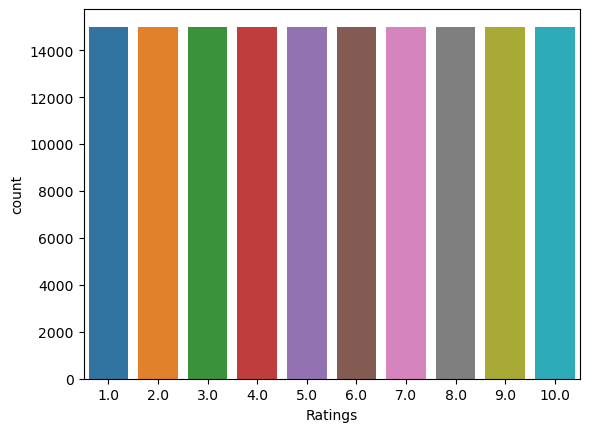

1.0     15000
2.0     15000
4.0     15000
3.0     15000
5.0     15000
6.0     15000
8.0     15000
7.0     15000
10.0    15000
9.0     15000
Name: Ratings, dtype: int64


In [18]:
# Checking for class imbalance
sns.countplot(x=df['Ratings'])
plt.show()
print(df['Ratings'].value_counts())

CPU times: total: 56.4 s
Wall time: 1min 27s


(-0.5, 1499.5, 799.5, -0.5)

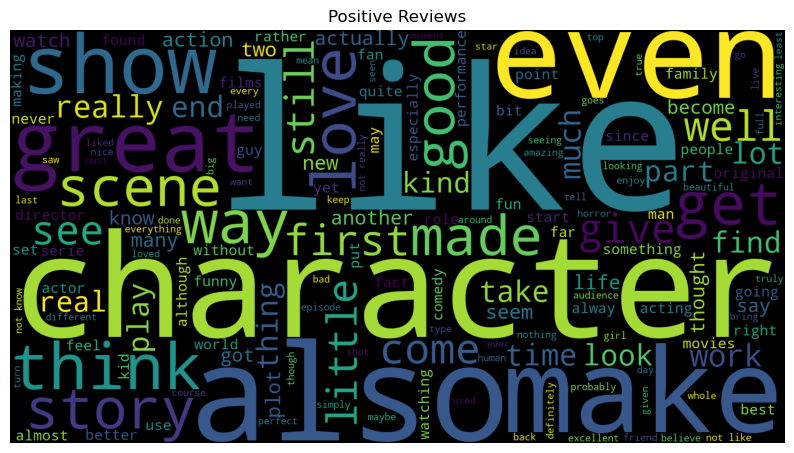

In [19]:
%%time
'''------Visualization of important words from Positive reviews'''
sentences = df['Clean_Reviews']
pos = ' '.join(map(str, sentences[df['Ratings']>=7]))
neg = ' '.join(map(str, sentences[df['Ratings']<=4]))

pos_wordcloud = WordCloud(width=1500, height=800,
                         background_color='black',
                         stopwords = stop_words,
                         min_font_size=15).generate(pos)

plt.figure(figsize=(10,10))
plt.imshow(pos_wordcloud)
plt.title('Positive Reviews')
plt.axis('off')

CPU times: total: 51.8 s
Wall time: 1min 19s


(-0.5, 1499.5, 799.5, -0.5)

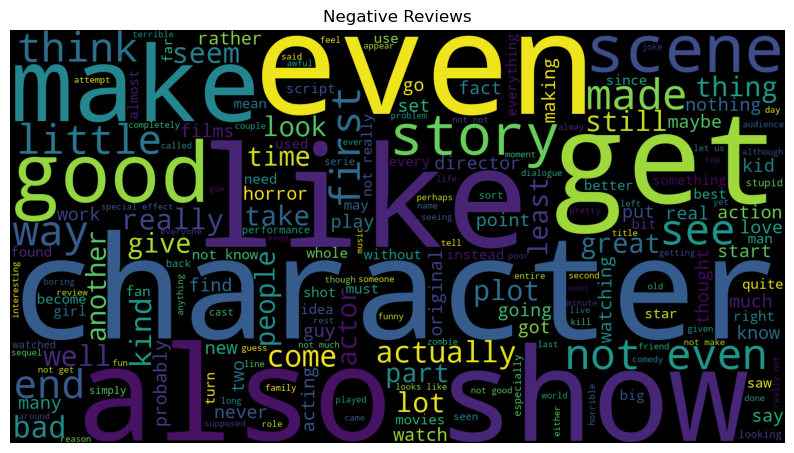

In [20]:
%%time
'''------Visualization of important words from Positive reviews'''

neg_wordcloud = WordCloud(width=1500, height=800,
                         background_color='black',
                         stopwords = stop_words,
                         min_font_size=15).generate(neg)

plt.figure(figsize=(10,10))
plt.imshow(neg_wordcloud)
plt.title('Negative Reviews')
plt.axis('off')

## Basic Statistic of Review data

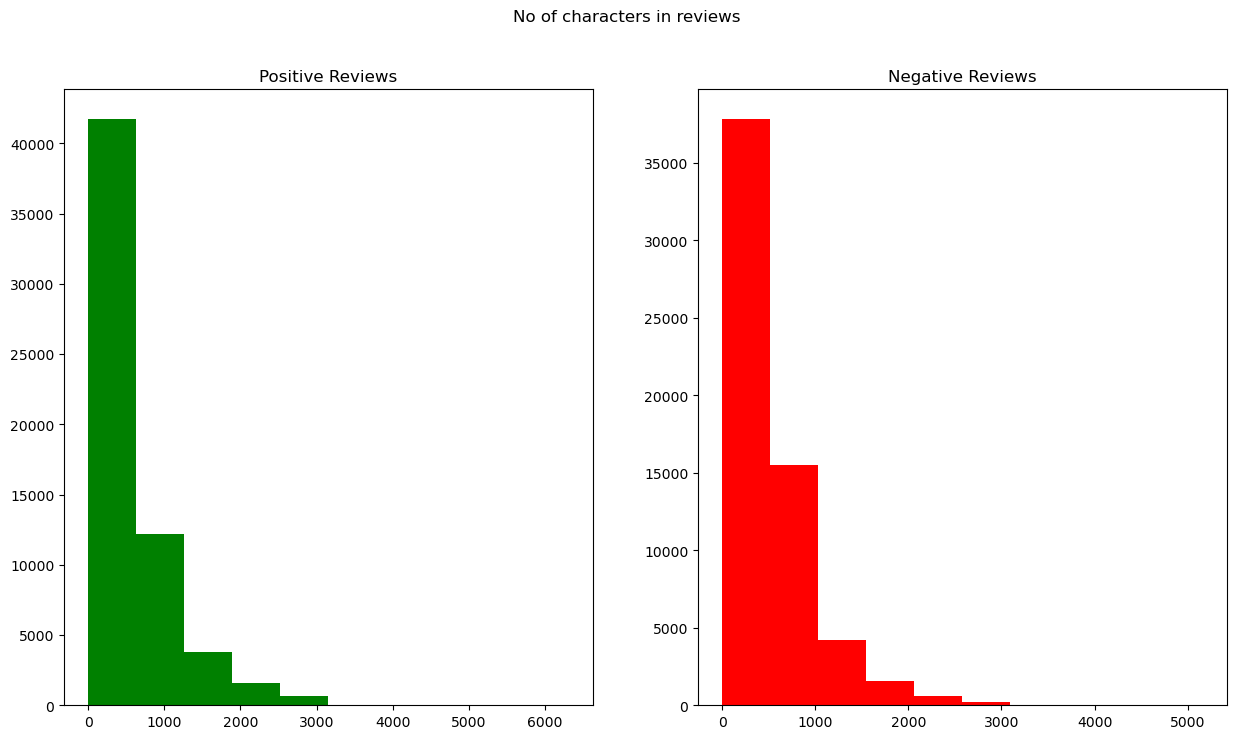

In [12]:
# Visualization of number of characters
figure, (pos_ax, neg_ax) = plt.subplots(1,2, figsize=(15,8))
len_pos_review = df[df['Ratings']>=7]['Clean_Reviews'].str.len()
pos_ax.hist(len_pos_review, color='green')
pos_ax.set_title('Positive Reviews')
len_neg_review = df[df['Ratings']<=4]['Clean_Reviews'].str.len()
neg_ax.hist(len_neg_review, color='red')
neg_ax.set_title('Negative Reviews')
plt.suptitle('No of characters in reviews')
plt.show()

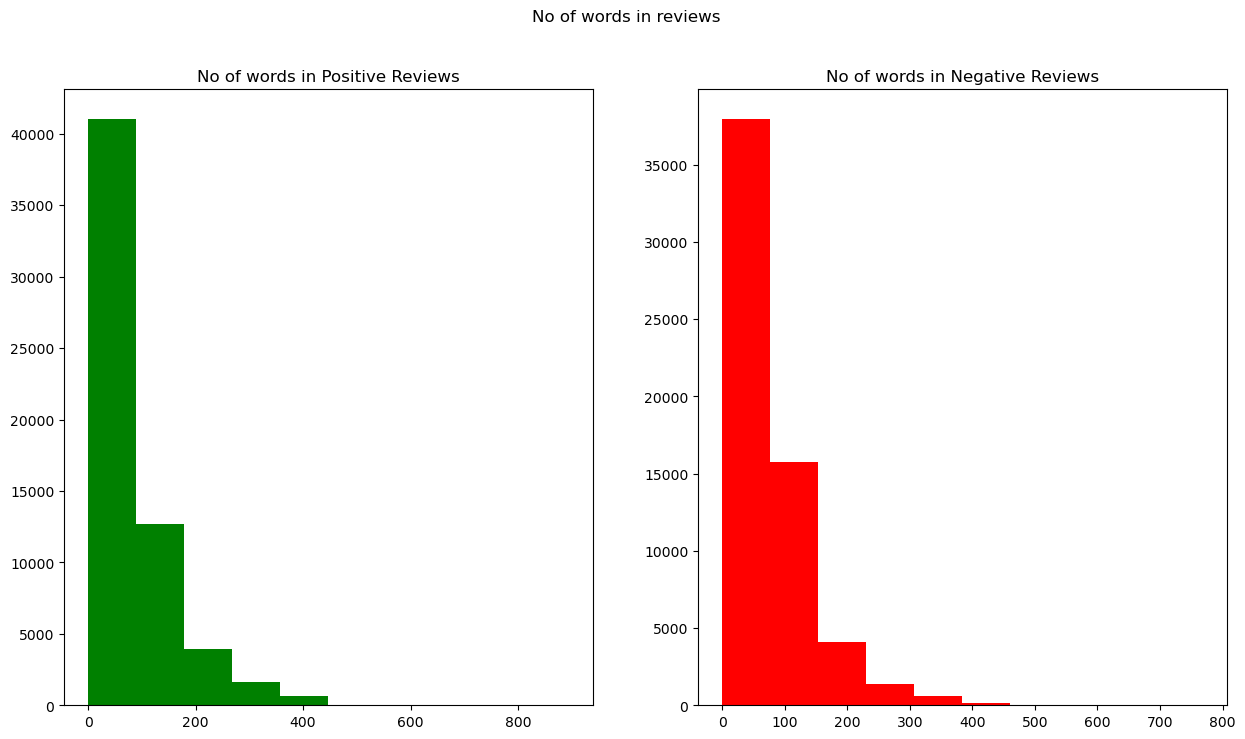

In [14]:
figure, (pos_ax, neg_ax) = plt.subplots(1,2, figsize=(15,8))
len_pos_review = df[df['Ratings']>=7]['Clean_Reviews'].str.split().map(lambda review: len(review))
pos_ax.hist(len_pos_review, color='green')
pos_ax.set_title('No of words in Positive Reviews')
len_neg_review = df[df['Ratings']<=4]['Clean_Reviews'].str.split().map(lambda review: len(review))
neg_ax.hist(len_neg_review, color='red')
neg_ax.set_title('No of words in Negative Reviews')
plt.suptitle('No of words in reviews')
plt.show()

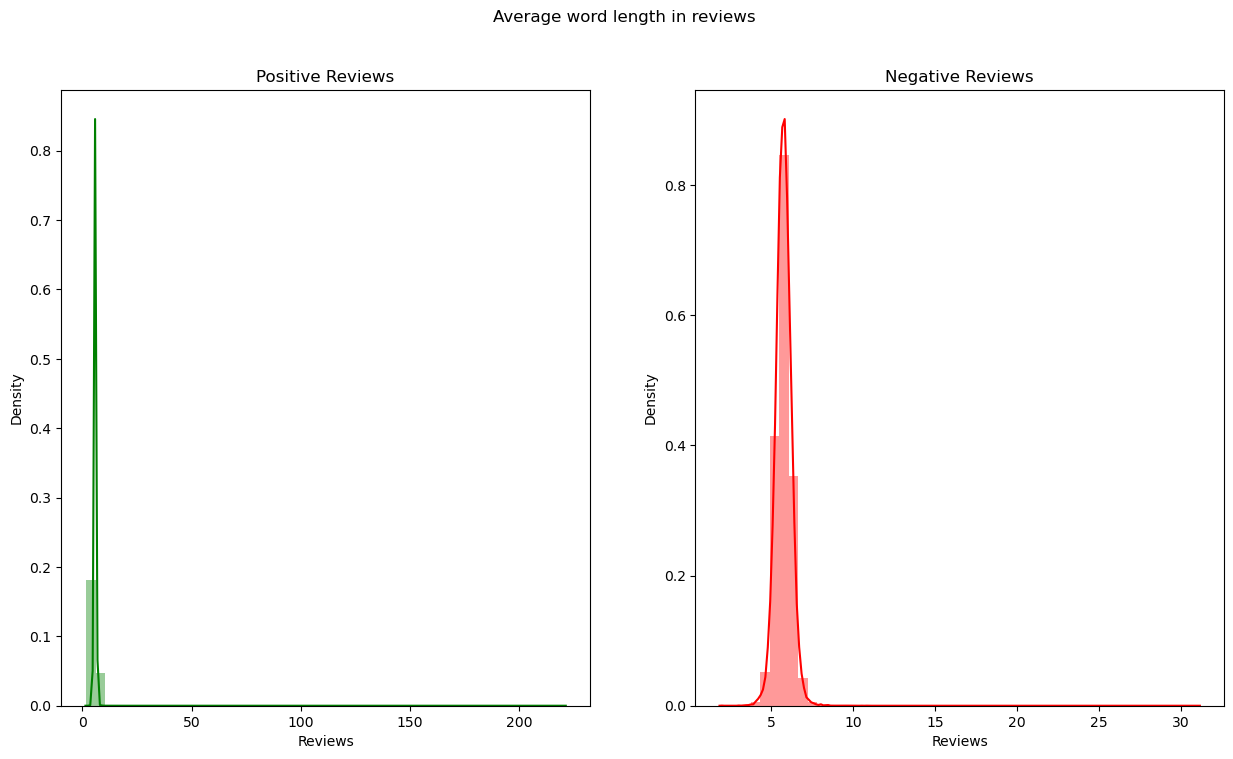

In [15]:
# Visualize average of words in reviews
figure, (pos_ax, neg_ax) = plt.subplots(1,2, figsize=(15,8))
pos_word = df[df['Ratings']>=7]['Clean_Reviews'].str.split().apply(lambda review: [len(word) for word in review])
sns.distplot(pos_word.map(lambda x: np.mean(x)), ax=pos_ax, color='green')
pos_ax.set_title('Positive Reviews')
neg_word = df[df['Ratings']<=4]['Clean_Reviews'].str.split().apply(lambda review: [len(word) for word in review])
sns.distplot(neg_word.map(lambda x: np.mean(x)), ax=neg_ax, color='red')
neg_ax.set_title('Negative Reviews')
plt.suptitle('Average word length in reviews')
plt.show()

In [11]:
# Get important feature by using CountVectorizer
def get_top_text_ngrams(corpus, n, g):
    vec = CountVectorizer(ngram_range=(g,g))
    bag_of_words = vec.fit_transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    word_freq = sorted(words_freq, key= (lambda x: x[1]), reverse=True)
    return word_freq[:n]

In [7]:
# corp = df.Reviews[df['Ratings']>=7]
# n = 20
# g = 1

# vec = CountVectorizer(ngram_range=(g,g)).fit(corp)
# bag_of_words = vec.transform(corp)
# bag_of_words.sum(axis=0)

matrix([[18,  9,  1, ...,  1,  2,  1]], dtype=int64)

In [22]:
# bag_of_words.sum(axis=0).shape

(1, 84198)

In [8]:
# vec.vocabulary_.items()

dict_items([('steven', 71064), ('seagal', 65539), ('getting', 29870), ('old', 52281), ('also', 2082), ('not', 51439), ('shape', 66594), ('years', 83431), ('ago', 1358), ('certainly', 11840), ('still', 71131), ('make', 45025), ('great', 31229), ('pretty', 57777), ('lot', 44018), ('money', 48555), ('spent', 69933), ('making', 45039), ('realistic', 60212), ('reminds', 61349), ('good', 30665), ('days', 17810), ('van', 79528), ('damme', 17444), ('backed', 5084), ('big', 7268), ('justice', 39611), ('colorful', 14139), ('filled', 26721), ('explosive', 25197), ('action', 674), ('dialogues', 19591), ('fight', 26674), ('scenes', 64906), ('actually', 730), ('takes', 73472), ('since', 67819), ('really', 60233), ('saw', 64684), ('perform', 55107), ('anything', 3131), ('close', 13634), ('aikido', 1477), ('balance', 5344), ('realism', 60210), ('utter', 79317), ('irrealism', 38043), ('got', 30867), ('remind', 61342), ('movies', 49219), ('genre', 29680), ('lots', 44031), ('folks', 27653), ('try', 76975

In [12]:
most_common_uni = get_top_text_ngrams(df.Clean_Reviews[df['Ratings']>=7],20,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ['Common_words', 'Counts'])
temp['Common_words'] = list(most_common_uni.keys())
temp['Count'] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title="Common words in Positive Reviews",
                width=700, height=700, color="Common_words")
fig.show()


In [13]:
# most_common_uni.keys()

dict_keys(['not', 'like', 'good', 'really', 'see', 'great', 'story', 'also', 'even', 'much', 'first', 'well', 'people', 'get', 'think', 'time', 'best', 'many', 'make', 'movies'])

In [13]:
most_common_uni = get_top_text_ngrams(df.Clean_Reviews[df['Ratings']>=7],20,2)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ['Common_words', 'Counts'])
temp['Common_words'] = list(most_common_uni.keys())
temp['Count'] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title="Common bigrams in Positive Reviews",
                width=700, height=700, color="Common_words")
fig.show()


In [14]:
most_common_uni = get_top_text_ngrams(df.Clean_Reviews[df['Ratings']>=7],20,3)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ['Common_words', 'Counts'])
temp['Common_words'] = list(most_common_uni.keys())
temp['Count'] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title="Common trigrams in Positive Reviews",
                width=700, height=700, color="Common_words")
fig.show()


In [15]:
pd.options.display.max_colwidth = 1000
df[["Reviews", "Ratings"]][(df["Ratings"]>=7)&(df["Reviews"].str.contains("not like | not want | not big fan"))].head()

Reviews  \
90193                                                                                                                                                                                                                                                                                                                                                                                              Starring: Carmen Electra and Brooke Hogan.Scary fish story that really has a lot going for it â Scares,Girls in bikinis and a creature that is NEW ! So let's go out to sea and study,No not like "The Suite Life On Deck",But more like Fred Olen Ray 'Showtime' movies in the water.There are villains without fins and people with Brains & Boobs.The creature effects are really good looking as CGI and just fun when do in real time and on set with actors interacting with the teeth plus.This ATOLL set would make a great tourist attraction with a re-tooled 'BRUCE the shark' that was replaced at Universal Studios,Florida.   
90198  Some folks really downgraded this movie and the two main stars, Casper Van Dien and Elelnia Eliniak by stating their careers were over because of this movie. Come on folks these two are professional actors and know how to act. This movie was not as horrible as some would have us believe nor did their careers end. Just because one did not like the movie is no reason to slam dunk the actors. The movie was actually quite good because of the two main stars It's quite conceivable for a character named Van Helsing not to know at one time in earths ancient culture he had a relative who was a vampire killer. As far as the script it was okay, the cinematography was good as far as one can be from being inside a spacecraft. The vampires exhibited great strength and stealth. They were tall dark and handsome or beautiful and tempting. In the end all the vampires were slain at the expense of most of the crew. To see which vampire remains and which crew members remain and how the movie ends which...   
90222  Alone in the Dark 2 is a fun little Supernatural Thriller with a good little cast & i enjoyed it, it looks like a movie & was actually filmed on film which was very rare back then, & even more rare now it's almost extinct, it's all digital now only "Tarantino" still uses film that I've heard of!!!\nAlso the film looks very good with good use of colour & a very slick look with lots of blue & green, a very cool opening actually with a view of new york city & central park, then we go down to central park where we meet 3 witch hunters running from the old Hag, it's very cool.\nThe first film was just ok, not great but not as terrible as all those way over the top reviews destroying it was saying, as there's alot of much worse films out there!!!\nThe music is really good, it's eerie & full of suspense & this little B-movie actually has a strong creepy atmosphere & feels like one of those rare Horror gems you find on t.v in the middle of the night, good solid film."Alone in the Dark 2" r...   
90251                                                                     You have to understand with these kinds of movies (boa vs. python,frankenfish, sasquatch hunters, rottweiler, tower of blood), you are not going to like it. You are going to think it was soo bad it was hilarious. Most importantly you cannot take it seriously as a movie. You have to also watch it with friends so you can all yell and say how stupid something was, or call something that is about to happen. I have seen about 8 movies like this one and I did not like one, but I had an amusing time watching it. WARNING: If you are looking for a scary movie or an interesting suspenseful movie DO NOT WATCH THIS! If you are on the other hand seeing something with friends, and you cant find a good comedy watch one of these. If you pick this movie out because you thought it would be cool, you should have been eliminated from the gene pool years ago. My personal favorite out of these 

In [16]:
most_common_uni = get_top_text_ngrams(df.Clean_Reviews[df['Ratings']>=7],20,4)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ['Common_words', 'Counts'])
temp['Common_words'] = list(most_common_uni.keys())
temp['Count'] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title="Common Four grams in Positive Reviews",
                width=700, height=700, color="Common_words")
fig.show()


In [17]:
most_common_uni = get_top_text_ngrams(df.Clean_Reviews[df['Ratings']>=7],20,5)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ['Common_words', 'Counts'])
temp['Common_words'] = list(most_common_uni.keys())
temp['Count'] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title="Common Five grams in Positive Reviews",
                width=700, height=700, color="Common_words")
fig.show()


In [20]:
pd.options.display.max_colwidth = 1000
df[["Reviews", "Ratings"]][(df["Ratings"]>=7)&(df["Reviews"].str.contains("mario mario mario | la la la | blah blah blah"))]

Reviews  \
91486   Nit-picking small details is an easy way to write a review. "The special effects were poor, the acting was bad, the plot was stupid, blah blah blah." But every director knows that to make a good film you have to have a great many small and large details come together to do just one thing: entertain. Even several "bad" bits can be used effectively if the movie makers keep the goal in mind. The makers of this movie didn't let their little troubles get in the way, they just used what they had to good effect.I personally feel that this film delivers in the entertainment category. I really had a good time watching it. While the usual fantasy film clichÃ©s abound, it manages to breathe new life into many of them by directly contrasting them to the real world reactions of normal earth folk. The idea is not necessarily original, but it always has potential.The mix of modern weaponry against fantasy weaponry is really what this film is all about. Seriously now, who HASN'T watched "Lord of t...   
91593                                                                                                                                                                                I have no idea what people are talking about who are ripping on this movie. Continuity, storyline, tension, blah blah blah. The story was fine, the continuity was fine, and there certainly WAS tension buildup leading to the scares. It's a found footage film so obviously the camera work is going to be a little shaky. Yes it's similar to Paranormal and Blair Witch... who cares? There are some great scares and scenes that creeped me out. Who cares if some of it is predictable? Who cares if it isn't realistic? It's a horror movie folks. Newsflash: most paranormal and zombie horror isn't realistic. Some of you have to remove the stick from your rear and just walk into these movies to enjoy them instead of trying to find things wrong.I highly recommend this movie. Not the best or scariest, but far far far from the worst.   
94640   I really enjoyed this movie; I think it might be the best Ferrell movie I've seen in a while. Yes it's goofy and silly, but I think a lot of the negative reviewers here are people who were fans of the original and are judging thru the haze of nostalgia. The original was every bit as goofy and ridiculous, it's just that this movie has the good sense to acknowledge it. And yes, it may not be appropriate for very young viewers as there is some sexual innuendo and cursing, but it does have a PG-13 rating so I don't know why you would be dragging young children to it anyways...'Land of the Lost' starts with a quirky and oddly arrogant scientist, played by Ferrell, claiming to Matt Lauer on 'Today' that we can solve our energy problems by tapping into inter-dimensional blah blah blah. Of course, no one believes him but a beautiful student from England (Friel) who convinces him to build his whatsit to open the portal to other dimensions. And of course they soon find themselves trapped in ...   
96062   Reguardless of the other votes and forums I've read about this flick.. Firstly I don't think its racist why its gotten bad ratings... and heres why... Firstly I am white, not that it should matter.. Movie idea was unoriginal.. and in my opinion that effected ppls ratings on this movie.. They couldn't see past the idea that it was not a NEW IDEA.... blah blah blah. People are just watching the movies to be entertained and if they've seen something similar there not entertained where as there's the few of us out there that can appreciate great acting and with this movie its exactly that.. I really enjoyed drumline.. Possibly because I was a drummer in school but I've also enjoyed quite a few of "dance movies" even enjoyed them enough to buy on DVD.. This movie Stomp The Yard.. I DO intend to buy on DVD as soon as its available.. I do recommend seeing this movie regardless of what the few other ppl have rated this movie on.. I feel it un

In [21]:
most_common_uni = get_top_text_ngrams(df.Clean_Reviews[df['Ratings']<=4],20,1)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ['Common_words', 'Counts'])
temp['Common_words'] = list(most_common_uni.keys())
temp['Count'] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title="Common words in Negative Reviews",
                width=700, height=700, color="Common_words")
fig.show()

In [22]:
most_common_uni = get_top_text_ngrams(df.Clean_Reviews[df['Ratings']<=4],20,2)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ['Common_words', 'Counts'])
temp['Common_words'] = list(most_common_uni.keys())
temp['Count'] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title="Common bigrams in Negative Reviews",
                width=700, height=700, color="Common_words")
fig.show()

In [23]:
most_common_uni = get_top_text_ngrams(df.Clean_Reviews[df['Ratings']<=4],20,3)
most_common_uni = dict(most_common_uni)
temp = pd.DataFrame(columns = ['Common_words', 'Counts'])
temp['Common_words'] = list(most_common_uni.keys())
temp['Count'] = list(most_common_uni.values())
fig = px.bar(temp, x="Count", y="Common_words", title="Common trigrams in Negative Reviews",
                width=700, height=700, color="Common_words")
fig.show()

In [9]:
pd.options.display.max_colwidth = 1000
df[["Reviews", "Ratings"]][(df["Ratings"]<=4)&(df["Clean_Reviews"].str.contains("good | great"))].head(100)

Reviews  \
3    If you saw the other previous spoof movies by these two horrible gentlemen, then you should know that this already will be bad. I'll tell you the truth, if you want to watch it as a brainless person (ironically meant for the stereotypical teenagers, which I am not) then you will laugh at it a bit. But if you judge it, even a little, the movie automatically fails. Why? Never ask that when it comes to these two men.Remember the good old Hollywood days whenever making a movie was about showing people a type of art, and also a story that kept you on the edge of your seat? Well whenever word hit that making films earned you loads of cash, then all these greedy people came in the picture and its quite pathetic. These two are no exception. We still have movie artists (most notably the genius that is Christopher Nolan). But these two guys just...well I've been writing so big words, let me put it in simple terms for these guys...These guys suck, they are not artists, but instead money cravi...   
6    I was given a free ticket to this film; so I can't complain that I was ripped off (except in that some 90 minutes of my life were irretrievably stolen from me). These sort of movies (Date Movie, Epic Movie, Meet the Spartans) haven't been funny for some time now but "Disaster Movie" has reached a new low. There wasn't one real laugh anywhere in the film, and most of the alleged "jokes" were actually painful. (There was a considerable amount of childish, mean-spirited stuff in the form of racist, sexist, and especially homophobic, garbage present, along with ample helpings of juvenile gross-outs.) None of the actors were even bothering to put up any pretense of acting. There is nothing hip, clever, or even mildly intelligent going on here. The entire film is from beginning to end crass, vulgar, irrational, and utterly humorless in any human sense. I know that in the past these sort of trash has made enough money to keep Seltzer et al., grinding them out but "Disaster Movie" may just...   
11                                                                                                                                                                                                                                                                                                I decided to go see this movie with some friends, just to have a laugh. We were hoping that it would be so bad that it would become funny. But it was just awful... I just cant take that kid seriously.Also, this movie just confirmed what we all knew, JB has an ego even bigger then Kayne West. The entire movie was like: "Look at me, i'm a talented singer and a good person! There is simply nothing that i can't do!"What the movie forgot to mention is that its his mommies fat cigar smoking managers that made JB. he's a puppet. This movie could make him look better, but it just buried him deeper. I'm starting to think that this was done on purpose because the fat cats want to get rid of him.Would not recommend.   
12   Right so everyone here on IMDb is pretty much committed to giving this "movie"(if you can call it that) 1 out of 10 to get it to no.1 on the bottom 100 list. Trust me, they're right.I went to see it because I knew there was no way I could criticize this movie without seeing it.However, the film lacks any artistic merit whatsoever. It is full of the latest and greatest pop sensations of the Youtube generation, but all these names and flashy lights are just stuffing in the under cooked turkey that is this show.At the heart of this presentation is the message to never give up on your dreams, however the whole movie is just Bieber smiling, looking pretty and grooming his lesbian hair, and as mentioned in previous reviews, the theater was full of tween girls screaming their heads off every time he inhaled or exhaled. Someone really needs to teach the modern generation about cinema etiquette, or at least tell them to shut up for 10 seconds. I honestly 

In [8]:
pd.options.display.max_colwidth = 1000
df[["Reviews", "Ratings"]][(df["Ratings"]<=4)&(df["Clean_Reviews"].str.contains("saturday night friday"))].head(100)

Reviews  \
7055   STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday Morning NO STARS End of Days A made for TV biopic of the pop icon Britney Spears (Natasha Bassett), from starting out with her breakthrough single Baby One More Time in 1999, where she was shoved into the limelight by her pushy mother Lynne (Nicole Oliver) and domineering manager Larry Rudolph (Peter Benson), who both naively thought she was old and mature enough to handle such massive media exposure and pushed her to lie about her virginity to keep up an illusion, through to the trials and turbulence of her relationships with Justin Timberlake (Nathan Keyes) and Kevin Federline (Clayton Chitty), before a revealing 2008 documentary aired.Sometimes, something can give you a really bad vibe, yet you still feel utterly compelled to see it. Your instinct can tell you it looks really bad, and you can see no end of bad reviews, and you can almost write a review before you've even seen it, but ...   
17427  STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday MorningWill (Joey Pollairi) is the new guy in high school, who stands out as a prime target for bullies. He soon makes friends with Jay (Zach Pearlman), Simon (Bubba Lewis) and Neil (Mark L. Young), three other social misfits who are not complete dorks but far from the coolest kids in school, either.It always spurs you on as a Brit when something home grown becomes a success, as I imagine it probably does for anyone from a small country that's not at the centre of the world (not anymore, anyway.) But it's a sad thing and a sign of the times when the only way to tell what a massive success it's been is when the Americans go and remake it. In fact, this is almost inevitable. And, inevitably, a whole lot worse.The best way I can describe The Inbetweeners USA is: imagine you've just read a really great Stephen King novel, and then see a film adaptation of it that is just like what you've rea...   
17818                   STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday Morning The premise behind this abysmal action thriller has a group of people going for a good old bit of paint ball, only to find themselves really fighting to stay alive as a barrage of real bullets are fired at them. But the characters are never developed or explored in any way, so it's impossible to care about any of them. Needless to say, there is no air of tension or suspense whatsoever, and the acting is so bad none of them have any life anyway, as though just running around shouting and screaming incoherently at each other gives them any life. Not that there was anything special to see there anyway, just the usual generic stereotypes typical for this genre. And here we have yet another film that hasn't learned the modern trend of shaking the camera around and darkening the lens is an off putting and annoying one rather than an endearing one. One to flee all round. *   
18138  STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday Morning I could go to great pains to write a long, in depth review of The Last Seven, but it's hard to write much more about it other than my summary above. Right from the opening sequence, with one of the lead characters wondering around a deserted London shouting out for 'anybody!', just like in the aforementioned film, it just feels like such a pale imitation of it that it hurts. In fact, it's almost as if the director knew he was practically copying it scene for scene and just gave up bothering to tell any sort of decent story of his own. As such, it just goes through the motions of the post apocalyptic thriller genre, with the usual stereo-typical set up and characters, without firmly establishing the back story behind the majority of humanity being wiped out and making no sense. Most baffling is Danny Dyer's role as some sort of blood cra

In [10]:
pd.options.display.max_colwidth = 1000
df[["Reviews", "Ratings"]][(df["Ratings"]>=7)&(df["Clean_Reviews"].str.contains("saturday night friday"))].head(100)

Reviews  \
92272   STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday Morning Three friends plot an ingenious armoured heist...they think their friendship is untouchable, but Vincent (Ryan Phillipe) whose father William (James Remar) is stuck in jail, suddenly turns on his two accomplices and leaves them for dead, including Sonny (50 Cent) who to makes ends meet robs a group of back street card dealers, whose money belongs to crime boss Biggs (Bruce Willis) who sends him on a mission to reclaim it. But when things turn pear shaped, he finds himself on the run from him, whilst pursuing his own personal mission of vengeance against Vincent.Whether it's the victim of recession era Hollywood, a poor US box office performance or simply not viewed as good enough, Setup is one such film that's arrived straight to DVD on these shores. It's certainly received quite a critical mauling from certain quarters, and doesn't seem to have much of a superior IMDb rating. In...   
93778   STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday Morning In a futuristic world, powerful corporations have taken over South East Asia and use it as a stomping ground to experiment their new ideas. Their latest failure has seen a deadly viral outbreak break out that has turned most of the population in to crazed, blood-thirsty zombies. Max Gatling (Dolph Lundgren) is a mercenary, hired by the head of the corporation responsible, to track down his wayward missing daughter Jude (Melanie Zanetti.) However, he's about to get dragged in to a whole lot more.Dolph does 28 Days Later! Has a certain zany appeal to it. But in the heat of it all, you have to remember, it's still a Dolph film, and as such can't get carried away with itself. And by the end, this off the beaten track little entry in to his back catalogue has become a most jumbled mix of horror, action and sci-fi that's a hell of a lot to keep up with in a film not even ninety minutes...   
95178   STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday MorningA contagious virus has spread across America that is causing the infected to slowly mutate in to cannibalistic zombies. Wade Vogel's (Arnold Schwarzenegger) daughter Maggie (Abigail Breslin) would be one such person, a young girl grimly aware of her terrible predicament. As the inevitable closes in, father and daughter bond in a final, all encompassing way, before they're drawn towards a terrifying final outcome.After his much hyped comeback a few years ago, Schwarzenegger has achieved what can only at best be called the most hit and miss results with his new batch of explosive, '80s flavoured action films. There was still something resembling an audience, but most people's tastes have cleaned up quite a bit. And so, out of nowhere, it seems, he delivers this latest offering, which on paper comes off just like one of his regular shoot 'em up type films, with him versus zombies. Bu...   
96216   STAR RATING: ***** Saturday Night **** Friday Night *** Friday Morning ** Sunday Night * Monday Morning This bizarre little horror film that appears to have come out of nowhere seems, judging by it's style and appearance, to be a homage to the grainy 1970s horror flicks from the likes of Dario Argento or other such luminaries. Playing out in various acts (i.e. Act I: Transmission and such...) maybe the feeling isn't so much homage as one of trying to be clever and post ironic, but either way the film has the feeling of a particular type of grainy horror flick.The driving force seems to be AJ Bowen's possessive husband, tracking his unfaithful spouse (Anessa Ramsey) after being driven mad by a twisted transmission in the tellys, leading to a whole succession of mad plot twists, until saviour (hopefully) arrives in the form of Justin Welborn's more rational bit on the side. There's plenty of blood splattered violence on display, some of

In [11]:
df.to_csv('..\data\Preprocessed_data.csv')